In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import torch
from fastai.vision.all import *
from typing import List, Union, Tuple
from fastai.callback.wandb import WandbCallback

from segmentation.model import SegmentationModel
from segmentation.train_utils import benchmark_inference_time, save_model_to_artifacts

In [3]:
PROJECT="CamVid"
ENTITY="av-demo"
IMAGE_SHAPE = (720, 960)
SEED = 42
RUN_NAME = "baseline-train-1"
JOB_TYPE = "baseline-train"

ARTIFACT_ID = "av-demo/CamVid/camvid-dataset:v0"

BATCH_SIZE = 16
IMAGE_RESIZE_FACTOR = 4
VALIDATION_SPLIT_PCT = 0.2
HIDDEN_DIM = 256
BACKBONE = "mobilenetv2_100"

LEARNING_RATE = 1e-3
TRAIN_EPOCHS = 10

INFERENCE_BATCH_SIZE = 8
NUM_WARMUP_ITERS = 10
NUM_INFERENCE_BENCHMARK_ITERS = 50



In [4]:
set_seed(SEED)

In [5]:
run = wandb.init(
    project=PROJECT,
    name=RUN_NAME,
    entity=ENTITY,
    job_type=JOB_TYPE,
    config={
        "artifact_id": ARTIFACT_ID,
        "image_shape": IMAGE_SHAPE,
        "batch_size": BATCH_SIZE,
        "image_resize_factor": IMAGE_RESIZE_FACTOR,
        "validation_split": VALIDATION_SPLIT_PCT,
        "hidden_dims": HIDDEN_DIM,
        "backbone": BACKBONE,
        "learning_rate": LEARNING_RATE,
        "train_epochs": TRAIN_EPOCHS,
        "inference_batch_size": INFERENCE_BATCH_SIZE,
        "num_warmup_iters": NUM_WARMUP_ITERS,
        "num_inference_banchmark_iters": NUM_INFERENCE_BENCHMARK_ITERS
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: capecape (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [6]:
artifact = run.use_artifact('av-demo/CamVid/run-32m1opp1-model:v0', type='model')
CHECKPOINT_FILE  = Path(artifact.download()).ls()[0]
CHECKPOINT_FILE.exists()

True

In [7]:
CHECKPOINT_FILE

Path('artifacts/run-32m1opp1-model:v0/run-32m1opp1-model')

## DataLoader for SegmentationDataLoader for Segmentation

In [8]:
def label_func(fn):
    return fn.parent.parent/"labels"/f"{fn.stem}_P{fn.suffix}"


def get_dataloaders(
    artifact_id: str, # the name of the artifact
    batch_size: int,  # the batch size for training, 2x for val
    resize_factor: int, # a integer resize factor for training
    validation_split_pct: float, # the validation percentage of data to be used in [0,1] 
    seed: int # the seed
):
    """Grab an artifact and creating a Pytorch DataLoader"""
    artifact = wandb.use_artifact(artifact_id, type='dataset')
    artifact_dir = Path(artifact.download())
    codes = np.loadtxt(artifact_dir/'codes.txt', dtype=str)
    fnames = get_image_files(artifact_dir/"images")
    class_labels = {k: v for k, v in enumerate(codes)}
    
    image_shape = load_image(fnames[0]).shape
    
    return SegmentationDataLoaders.from_label_func(
        artifact_dir,
        bs=batch_size,
        fnames=fnames,
        label_func=label_func,
        codes=codes,
        item_tfms=Resize((
            image_shape[0] // resize_factor,
            image_shape[1] // resize_factor
        )),
        valid_pct=validation_split_pct,
        seed=seed
    ), class_labels

wandb: Downloading large artifact camvid-dataset:v0, 1456.69MB. 1422 files... Done. 0:0:0


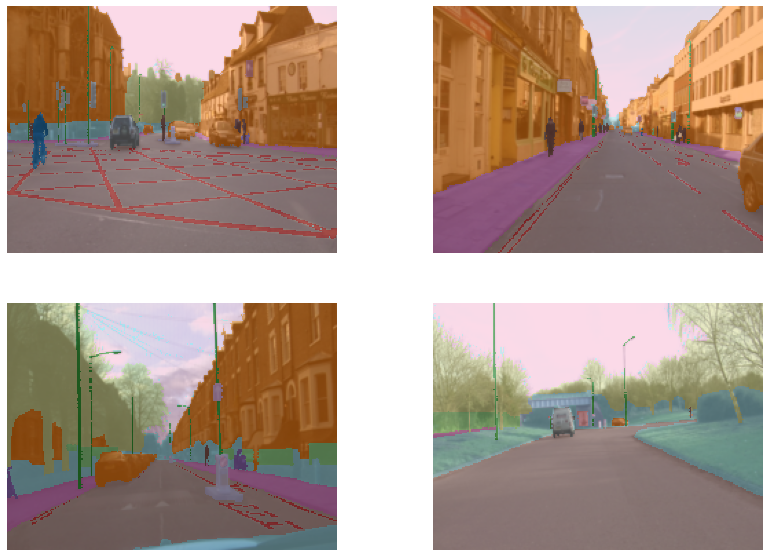

In [9]:
data_loader, class_labels = get_dataloaders(
    artifact_id=ARTIFACT_ID,
    batch_size=BATCH_SIZE,
    resize_factor=IMAGE_RESIZE_FACTOR,
    validation_split_pct=VALIDATION_SPLIT_PCT,
    seed=SEED
)

data_loader.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14, 10))

## Training and Inference

Let's log a bucnh of useful data for model evaluation

In [10]:
def get_model_parameters(model):
    "Get total number of model params"
    with torch.no_grad():
        num_params = sum(p.numel() for p in model.parameters())
    return num_params

In [11]:
def get_predictions(learner, max_n=None):
    "Return the samples = (x,y) and outputs (model predictions decoded), and predictions (raw preds)" 
    inputs, predictions, targets, outputs = learner.get_preds(with_input=True, with_decoded=True)
    x, y, samples, outputs = learner.dls.valid.show_results(
        tuplify(inputs) + tuplify(targets), outputs, show=False, max_n=max_n
    )
    return samples, outputs, predictions

In [12]:
def get_learner(
    data_loader,
    backbone: str,
    hidden_dim: int,
    num_classes: int,
    checkpoint_file: Union[None, str, Path],
    loss_func,
    metrics: List,
    log_preds: bool = False
):
    model = SegmentationModel(backbone, hidden_dim, num_classes=num_classes)
    save_model_callback = SaveModelCallback(fname=f"unet_{backbone}")
    mixed_precision_callback = MixedPrecision()
    wandb_callback = WandbCallback(log_preds=log_preds)
    learner = Learner(
        data_loader,
        model,
        loss_func=loss_func,
        metrics=metrics,
        cbs=[save_model_callback, mixed_precision_callback, wandb_callback],
    )
    if checkpoint_file is not None:
        load_model(checkpoint_file, learner.model, opt=None, with_opt=False)
        # learner.load(checkpoint_file)
    return learner

In [13]:
learner = get_learner(
    data_loader,
    backbone=BACKBONE,
    hidden_dim=HIDDEN_DIM,
    num_classes=len(class_labels),
    checkpoint_file=CHECKPOINT_FILE,
    loss_func=FocalLossFlat(axis=1),
    metrics=[DiceMulti(), foreground_acc],
    log_preds=True,
)

In [14]:
samples, outputs, predictions = get_predictions(learner)

In [15]:
(img, targ), dec_pred, raw_pred = samples[0], outputs[0][0], predictions[0]

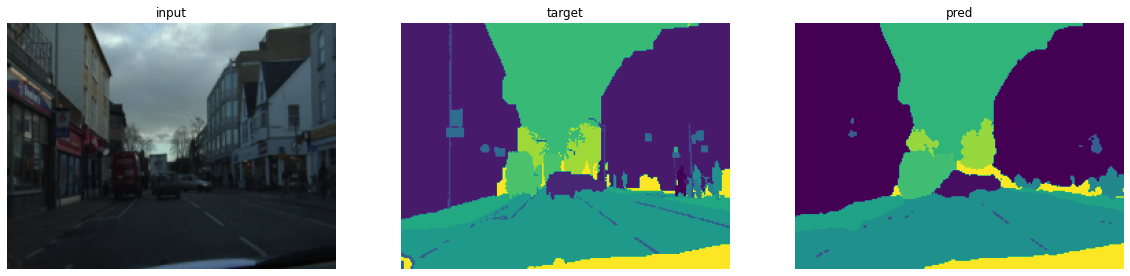

In [16]:
show_images([img, targ, dec_pred], titles=["input", "target", "pred"], figsize=(20,10))

In [17]:
targ.shape

torch.Size([180, 240])

In [18]:
raw_pred.shape

torch.Size([32, 180, 240])

In [19]:
foreground_acc(raw_pred.unsqueeze(0), targ.unsqueeze(0)).item()

0.9262962937355042

In [24]:
def dice_per_class(inp, targ, class_labels):
    "Compute dice per class"
    dice_scores = {}
    eps = 1e-6
    for c in range(inp.shape[0]):
        dec_preds = inp.argmax(dim=0)
        p = torch.where(dec_preds == c, 1, 0)
        t = torch.where(targ == c, 1, 0)
        c_inter = (p*t).float().sum().item()
        c_union = (p+t).float().sum().item()
        if c_union:
            dice_scores[c] = 2.*c_inter/(c_union + eps)
        else:
            dice_scores[c] = -1
    return {class_labels[c]:dice_scores[c] for c in range(inp.shape[0])}

In [26]:
dice_per_class(raw_pred, targ, class_labels)

{'Animal': -1,
 'Archway': -1,
 'Bicyclist': 0.0,
 'Bridge': -1,
 'Building': 0.9628627899468724,
 'Car': 0.8968456940350846,
 'CartLuggagePram': -1,
 'Child': -1,
 'Column_Pole': 0.0,
 'Fence': -1,
 'LaneMkgsDriv': 0.3253333324657778,
 'LaneMkgsNonDriv': -1,
 'Misc_Text': 0.26691729273135845,
 'MotorcycleScooter': -1,
 'OtherMoving': 0.0,
 'ParkingBlock': -1,
 'Pedestrian': 0.4335106377213954,
 'Road': 0.9633562903652092,
 'RoadShoulder': -1,
 'Sidewalk': 0.8596112307920766,
 'SignSymbol': 0.0,
 'Sky': 0.975008558646011,
 'SUVPickupTruck': 0.8838804503263692,
 'TrafficCone': -1,
 'TrafficLight': 0.0,
 'Train': -1,
 'Tree': 0.7611336028536773,
 'Truck_Bus': -1,
 'Tunnel': -1,
 'VegetationMisc': -1,
 'Void': 0.7712937668807316,
 'Wall': -1}

In [33]:
list(class_labels.values())[0]

numpy.str_

In [27]:
def create_wandb_table(samples, outputs, predictions, class_labels):
    "Creates a wandb table with predictions and targets side by side"
    table = wandb.Table(columns=["Image", "Predicted_Mask", "Ground_Truth"]+ list(class_labels.values()) + ["Foreground Acc"])
    
    for (image, label), pred_label, prediction, in tqdm(zip(samples, outputs, predictions)):
        dice_scores = list(dice_per_class(prediction, label, class_labels).values())
        facc = foreground_acc(prediction, label)
        image = image.permute(1, 2, 0)
        table.add_data(
            wandb.Image(image),
            wandb.Image(
                image,
                masks={
                    "predictions":  {
                        'mask_data':  pred_label[0].numpy(),
                        'class_labels':class_labels
                    }
                }
            ),
            wandb.Image(
                image,
                masks={
                    "ground_truths": {
                        'mask_data': label.numpy(),
                        'class_labels':class_labels
                    }
                }
            ),
            *dice_score,
            facc,
        )
    return table

In [28]:
create_wandb_table(samples, outputs, predictions, class_labels)

AssertionError: columns argument expects list of strings or ints

In [32]:
# learner.fine_tune(10, 1e-3)
learner.fit_one_cycle(TRAIN_EPOCHS, LEARNING_RATE)

epoch,train_loss,valid_loss,dice_multi,foreground_acc,time


KeyboardInterrupt: 

In [31]:
%debug

> /home/paperspace/mambaforge/envs/fastai/lib/python3.9/site-packages/wandb/data_types.py(262)_assert_valid_columns()
    260             valid_col_types.append(unicode)  # noqa: F821 (unicode is in py2)
    261         assert type(columns) is list, "columns argument expects a `list` object"
--> 262         assert len(columns) == 0 or all(
    263             [type(col) in valid_col_types for col in columns]
    264         ), "columns argument expects list of strings or ints"



ipdb>  columns


['Image', 'Predicted_Mask', 'Ground_Truth', 'Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone', 'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall', 'Foreground Acc']


ipdb>  [type(col) in valid_col_types for col in columns]


*** NameError: name 'valid_col_types' is not defined


ipdb>  [type(col) for col in columns]


[<class 'str'>, <class 'str'>, <class 'str'>, <class 'numpy.str_'>, <class 'numpy.str_'>, <class 'numpy.str_'>, <class 'numpy.str_'>, <class 'numpy.str_'>, <class 'numpy.str_'>, <class 'numpy.str_'>, <class 'numpy.str_'>, <class 'numpy.str_'>, <class 'numpy.str_'>, <class 'numpy.str_'>, <class 'numpy.str_'>, <class 'numpy.str_'>, <class 'numpy.str_'>, <class 'numpy.str_'>, <class 'numpy.str_'>, <class 'numpy.str_'>, <class 'numpy.str_'>, <class 'numpy.str_'>, <class 'numpy.str_'>, <class 'numpy.str_'>, <class 'numpy.str_'>, <class 'numpy.str_'>, <class 'numpy.str_'>, <class 'numpy.str_'>, <class 'numpy.str_'>, <class 'numpy.str_'>, <class 'numpy.str_'>, <class 'numpy.str_'>, <class 'numpy.str_'>, <class 'numpy.str_'>, <class 'numpy.str_'>, <class 'str'>]


ipdb>  q


In [ ]:
learner.show_results(max_n=4, figsize=(14, 10))

In [ ]:
samples, outputs, _ = get_predictions(learner)
table = create_wandb_table(samples, outputs, class_labels)
wandb.log({f"Baseline_Predictions_{run.name}": table})

In [ ]:
model = learner.model.eval()
torch.cuda.empty_cache()
wandb.log({"Model_Parameters": get_model_parameters(model)})
wandb.log({
    "Inference_Time": benchmark_inference_time(
        model=model,
        batch_size=INFERENCE_BATCH_SIZE,
        image_shape=IMAGE_SHAPE,
        num_warmup_iters=NUM_WARMUP_ITERS,
        num_iter=NUM_INFERENCE_BENCHMARK_ITERS,
        seed=SEED
    )
})

In [ ]:
save_model_to_artifacts(
    model=model,
    model_name=f"unet_{BACKBONE}",
    image_shape=IMAGE_SHAPE,
    artifact_name=f"{run.name}-saved-model",
    metadata={
        "backbone": BACKBONE,
        "hidden_dims": HIDDEN_DIM,
        "input_size": IMAGE_SHAPE,
        "class_labels": class_labels
    }
)

In [ ]:
run.finish()